In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, GlobalAveragePooling2D

2024-02-25 15:31:14.950827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 15:31:14.950927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 15:31:15.123492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the path to your dataset
data_path_train = "/kaggle/input/d/reshmasherine/covid19-dataset/Covid19 Dataset/Train"
data_path_val="/kaggle/input/d/reshmasherine/covid19-dataset/Covid19 Dataset/Val"
# Specify parameters
img_size = (256, 256)
batch_size = 32

# Use ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Create generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    data_path_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)
validation_generator = val_datagen.flow_from_directory(
    data_path_val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1058 images belonging to 2 classes.
Found 356 images belonging to 2 classes.


In [3]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Corona Virus Disease
1 : Normal


In [4]:
from tensorflow.keras.optimizers import RMSprop
# Load the VGG16 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation='sigmoid'))
# Compile the model
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [5]:
history=model.fit(train_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5


I0000 00:00:1708875124.520123     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 [==============================] - 64s 2s/step - loss: 0.1268 - accuracy: 0.9490 - val_loss: 0.0959 - val_accuracy: 0.9607
Epoch 2/5
34/34 [==============================] - 39s 1s/step - loss: 0.0650 - accuracy: 0.9735 - val_loss: 0.0622 - val_accuracy: 0.9747
Epoch 3/5
34/34 [==============================] - 39s 1s/step - loss: 0.0329 - accuracy: 0.9877 - val_loss: 0.0281 - val_accuracy: 0.9860
Epoch 4/5
34/34 [==============================] - 39s 1s/step - loss: 0.0345 - accuracy: 0.9877 - val_loss: 0.0465 - val_accuracy: 0.9803
Epoch 5/5
34/34 [==============================] - 39s 1s/step - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.0198 - val_accuracy: 0.9916


In [6]:
model.save("Two_class_inceptionv3.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
data_path_test="/kaggle/input/d/reshmasherine/covid19-dataset/Covid19 Dataset/Test"
test_generator = test_datagen.flow_from_directory(
    data_path_test,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Evaluate the model on the test set
results = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

Found 260 images belonging to 2 classes.
9/9 [==============================] - 9s 1s/step - loss: 0.0329 - accuracy: 0.9808
Test Loss: 0.03292437642812729
Test Accuracy: 0.9807692170143127


In [8]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=labels.values()))

9/9 [==============================] - 8s 716ms/step
                      precision    recall  f1-score   support

Corona Virus Disease       0.98      0.98      0.98       130
              Normal       0.98      0.98      0.98       130

            accuracy                           0.98       260
           macro avg       0.98      0.98      0.98       260
        weighted avg       0.98      0.98      0.98       260



9/9 [==============================] - 6s 723ms/step


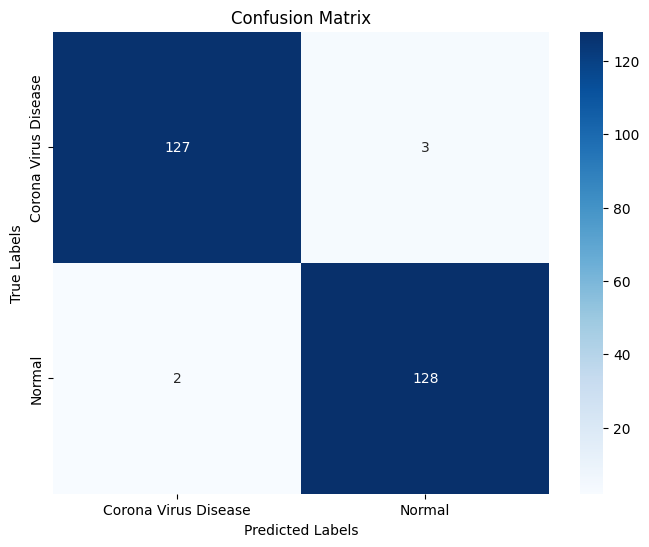

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Predict the labels using the model
predictions = model.predict(test_generator)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 3s 3s/step
Original Prediction: Corona Virus Disease


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


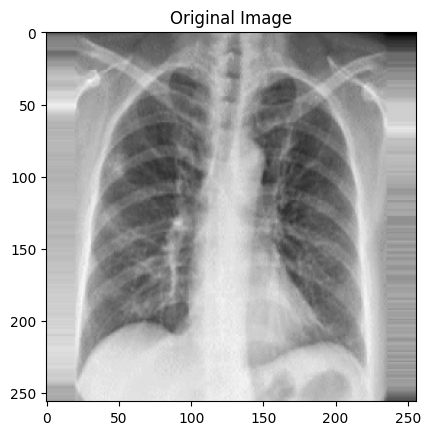

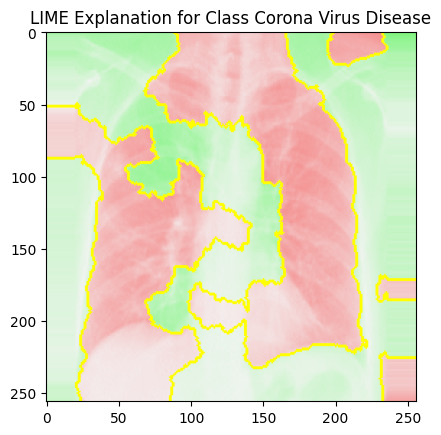

In [10]:
import lime
from lime import lime_image
from keras.models import load_model
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

# Load the trained multiclass model
#model = load_model("your_multiclass_model.h5")  # Replace with the actual path to your model

# Define a custom segmentation algorithm
#segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# Create a LIME explainer with the custom segmentation algorithm
explainer = lime_image.LimeImageExplainer()

# Load and preprocess an image for LIME interpretation
img_for_lime, _ = validation_generator.next()  # Load an example image from the validation set
img_for_lime = img_for_lime[0]  # Take the first image from the batch

# Add a dummy RGB channel to the grayscale image
img_for_lime_rgb = np.stack((img_for_lime[:, :, 0],) * 3, axis=-1)

# Get the original prediction
original_prediction = model.predict(np.expand_dims(img_for_lime, axis=0))
print("Original Prediction:", labels[np.argmax(original_prediction)])

# Explain the prediction using LIME for top three classes with custom segmentation
explanation = explainer.explain_instance(
    img_for_lime_rgb,
    model.predict,
    top_labels=1,  # Specify the number of top classes for explanation
    hide_color=0,
    num_samples=1000
)

# Display the original image
plt.imshow(img_for_lime[:, :, 0], cmap='gray')  # Assuming images are grayscale
plt.title('Original Image')
plt.show()

# Display the LIME explanation for the top three predictions
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=False,
        num_features=img_size[0],  # Specify based on your image dimensions
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f'LIME Explanation for Class {labels[label]}')
    plt.show()


1/1 [==============================] - 0s 27ms/step
Original Prediction: Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


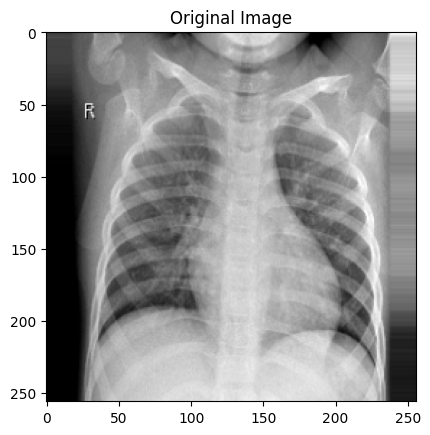

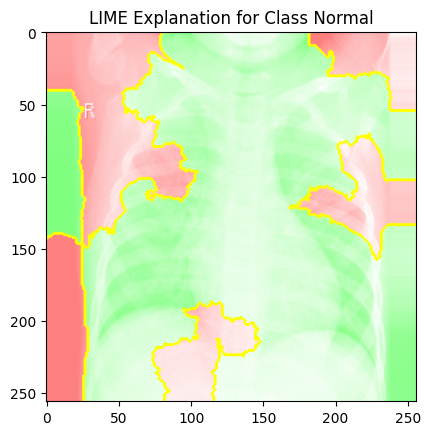

In [13]:
import lime
from lime import lime_image
from keras.models import load_model
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

# Load the trained multiclass model
#model = load_model("your_multiclass_model.h5")  # Replace with the actual path to your model

# Define a custom segmentation algorithm
#segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# Create a LIME explainer with the custom segmentation algorithm
explainer = lime_image.LimeImageExplainer()

# Load and preprocess an image for LIME interpretation
img_for_lime, _ = validation_generator.next()  # Load an example image from the validation set
img_for_lime = img_for_lime[0]  # Take the first image from the batch

# Add a dummy RGB channel to the grayscale image
img_for_lime_rgb = np.stack((img_for_lime[:, :, 0],) * 3, axis=-1)

# Get the original prediction
original_prediction = model.predict(np.expand_dims(img_for_lime, axis=0))
print("Original Prediction:", labels[np.argmax(original_prediction)])

# Explain the prediction using LIME for top three classes with custom segmentation
explanation = explainer.explain_instance(
    img_for_lime_rgb,
    model.predict,
    top_labels=1,  # Specify the number of top classes for explanation
    hide_color=0,
    num_samples=1000
)

# Display the original image
plt.imshow(img_for_lime[:, :, 0], cmap='gray')  # Assuming images are grayscale
plt.title('Original Image')
plt.show()

# Display the LIME explanation for the top three predictions
for label in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=False,
        num_features=img_size[0],  # Specify based on your image dimensions
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f'LIME Explanation for Class {labels[label]}')
    plt.show()
